In [1]:
path = r"/home/mb/college/bda/BDA/datasets/Iris.csv"

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("Iris Multivariate Analysis").getOrCreate()

df = spark.read.csv(path, header=True, inferSchema=True)

# df.show()

indexer = StringIndexer(inputCol="Species", outputCol="Species_Index")

df_cols = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm", "Species_Index"]

# print(df_cols)

assembler = VectorAssembler(inputCols=df_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled")
pca = PCA(inputCol="scaled", outputCol="pca_features", k=3)
lr = LogisticRegression(featuresCol="pca_features", labelCol="Species_Index", maxIter=100)


pipeline = Pipeline(stages=[indexer, assembler, scaler, pca, lr])

train, test = df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train)

predictions = model.transform(test)

labels = model.stages[0].labels
converter = IndexToString(inputCol="prediction", outputCol="predicted_species", labels=labels)
predictions = converter.transform(predictions)

evaluator = MulticlassClassificationEvaluator(
    labelCol="Species_Index", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")

predictions.show(truncate=False)

# spark.stop()


25/04/21 22:20:02 WARN Utils: Your hostname, manthan resolves to a loopback address: 127.0.1.1; using 192.168.1.9 instead (on interface wlp0s20f3)
25/04/21 22:20:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/21 22:20:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/21 22:20:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Test Accuracy: 1.0000
+---+-------------+------------+-------------+------------+---------------+-------------+---------------------+------------------------------------------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------------+----------+-----------------+
|Id |SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|Species        |Species_Index|features             |scaled                                                                                          |pca_features                                                |rawPrediction                                               |probability                                                       |prediction|predicted_species|
+---+-------------+------------+-------------+------------+---------------+-------------+---------------------+-------------

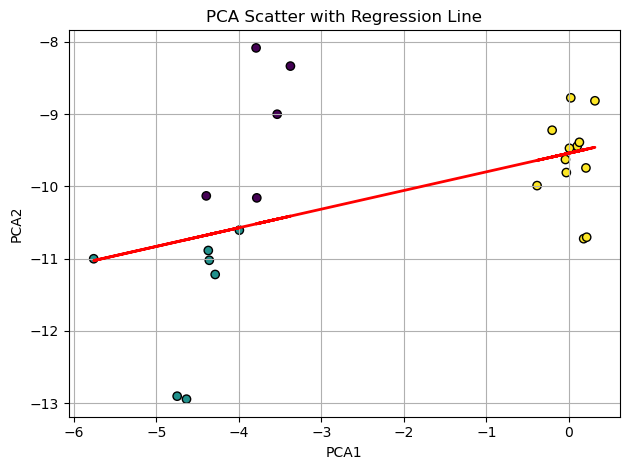

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas
data = predictions.select("pca_features", "Species_Index").toPandas()
data[["x", "y", _]] = pd.DataFrame(data["pca_features"].tolist(), index=data.index)

# Fit a simple regression line using numpy
import numpy as np
m, b = np.polyfit(data["x"], data["y"], 1)

# Plot points and regression line
plt.scatter(data["x"], data["y"], c=data["Species_Index"], cmap="viridis", edgecolor="k")
plt.plot(data["x"], m*data["x"] + b, color="red", linewidth=2)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Scatter with Regression Line")
plt.grid(True)
plt.tight_layout()
plt.show()